<a href="https://colab.research.google.com/github/saritmaitra/Natural-Gas_Paul/blob/master/Sarit_16%20Mar%2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data mining approach**


## **Data ingestion, processing, feature engineering and machine learning**

#**Code without ngrok**

In [0]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
!pip install python_wtd
from python_wtd import WTD
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
!pip install fredapi
from fredapi import Fred
!pip install EIA_python
import eia
!pip install python_wtd
from python_wtd import WTD
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor
import xgboost as xgb
!pip install ffn
import ffn

## **Current Spot price ($/Mbtu)**
(Release Date: 3/11/2020; Next Release Date: 3/18/2020 )

In [0]:
# Henry Hub Spot Price, Daily (Release Date: 3/11/2020; Next Release Date: 3/18/2020 )
print('\033[4mHenry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    hh_spot = pd.DataFrame(series_search)
    return hh_spot

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.RNGWHHD.D'
      hh_spot = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(hh_spot))
      return hh_spot;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

hh_spot = main()
hh_spot = hh_spot.rename({'Henry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)': 'hh_spot'}, axis = 'columns')
hh_spot = hh_spot.reset_index()
hh_spot['index'] = pd.to_datetime(hh_spot['index'].str[:-3], format='%Y %m%d')
hh_spot['Date']= pd.to_datetime(hh_spot['index']) 
hh_spot.set_index('Date', inplace=True) # setting index column
hh_spot = hh_spot.loc['2000-01-01':,['hh_spot']] # setting date range
hh_spot = hh_spot.astype(float)
#print(hh_spot) 
print('\n')

print('\033[4mCurrent spot price\033[0m')
print(hh_spot.tail(1))

Henry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



Current spot price
            hh_spot
Date               
2020-03-05     1.89


## **Importing API's**

In [0]:
# Natural Gas continuous contract
print('\033[4mNatural Gas continuous contract 1\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,]
#NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]

# Cushing, OK WTI Spot Price FOB, Daily
print('\033[4mWTI Spot Price FOB, Daily (Dollars per Barrel)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    wti = pd.DataFrame(series_search)
    return wti

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.RWTC.D'
      wti = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(wti))
      return wti;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

wti = main()
wti = wti.rename({'Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)': 'wti'}, axis = 'columns')
wti = wti.reset_index()
wti['index'] = pd.to_datetime(wti['index'].str[:-3], format='%Y %m%d')
wti['Date']= pd.to_datetime(wti['index']) 
wti.set_index('Date', inplace=True) # setting index column
wti = wti.loc['2000-01-01':,['wti']] # setting date range
wti = wti.astype(float)
#print(wti) 
#print('\n')

## GDP data
print('\033[4mUS GDP Data\033[0m')
fred = Fred(api_key='59c798fcda5850ef874412d269fd2378')
gdp = fred.get_series_as_of_date('GDP', '2020-01-31')
gdp = gdp.rename({'date': 'Date', 'value': 'gdp'}, axis = 'columns')
gdp.set_index('Date', inplace=True) # setting index column
gdp = gdp.loc['2000-01-01':'2020-02-02',['gdp']] # setting date range
gdp.replace({pd.NaT: "0"}, inplace=True) # replacing NaT with 0
gdp = gdp.ffill().bfill()
gdp = gdp.reset_index().drop_duplicates('Date').set_index('Date') # dropping duplicate concurrence
gdp = pd.DataFrame(gdp)
gdp = gdp.astype(float)
gdp = gdp.resample('B').ffill()
gdp = gdp/4
#print(gdp)
#print('\n')

# U.S. Natural Gas Marketed Production, Monthly
print('\033[4mNatural Gas Marketed Production, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    prod = pd.DataFrame(series_search)
    return prod

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9050US2.M'
      prod = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(prod))
      return prod;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

prod = main()
prod = prod.rename({'U.S. Natural Gas Marketed Production, Monthly (Million Cubic Feet)': 'prod'}, axis = 'columns')
prod = prod.reset_index()
prod['Date']= pd.to_datetime(prod['index']) 
prod.set_index('Date', inplace=True) # setting index column
prod = prod.loc['2000-01-01':,['prod']] # setting date range
prod = prod.astype(float)
prod = prod.resample('B').ffill()
prod = prod/21
#print(prod)
#print('\n')


# U.S. Natural Gas Gross Withdrawals, Monthly
print('\033[4mNatural Gas Gross Withdrawals, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    withdrawals = pd.DataFrame(series_search)
    return withdrawals

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9010US2.M' 
      withdrawals = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(withdrawals))
      return withdrawals;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

withdrawals = main()
withdrawals = withdrawals.rename({'U.S. Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)': 'withdrawals'}, axis = 'columns')
withdrawals = withdrawals.reset_index()
withdrawals['Date']= pd.to_datetime(withdrawals['index']) 
withdrawals.set_index('Date', inplace=True) # setting index column
withdrawals = withdrawals.loc['2000-01-01':,['withdrawals']] # setting date range
withdrawals = withdrawals.astype(float)
withdrawals = withdrawals.resample('B').bfill().ffill()
withdrawals = withdrawals/21
#print(withdrawals)
#print('\n')

# U.S. Natural Gas Underground Storage Volume, Monthly
print('\033[4mNatural Gas Underground Storage Volume, Monthly\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    storage = pd.DataFrame(series_search)
    return storage

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N5030US2.M '
      storage = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(storage))
      return storage;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

storage = main()
storage = storage.rename({'U.S. Natural Gas Underground Storage Volume, Monthly (Million Cubic Feet)': 'storage'}, axis = 'columns')
storage = storage.reset_index()
storage['Date']= pd.to_datetime(storage['index']) 
storage.set_index('Date', inplace=True) # setting index column
storage = storage.loc['2000-01-01':,['storage']] # setting date range
stoarge = storage.astype(float)
storage = storage.resample('B').bfill().ffill()
storage = storage/21
#print(storage)
#print('\n')

# U.S. Natural Gas Exports, Monthly
print('\033[4mNatural Gas Exports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    export = pd.DataFrame(series_search)
    return export

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9133US2.M'
      export = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(export))
      return export;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

export = main()
export = export.rename({'Liquefied U.S. Natural Gas Exports, Monthly (Million Cubic Feet)': 'export'}, axis = 'columns')
export = export.reset_index()
export['Date']= pd.to_datetime(export['index']) 
export.set_index('Date', inplace=True) # setting index column
export = export.loc['2000-01-01':,['export']] # setting date range
export = export.astype(float)
export = export.resample('B').bfill().ffill()
export = export/21
#print(export)
#print('\n')

# natural gas total consumption (monthly))
print('\033[4mNatural Gas Total Consumption, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    consumption = pd.DataFrame(series_search)
    return consumption

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9140US2.M'
      consumption = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(consumption))
      return consumption;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

consumption = main()
consumption = consumption.rename({'U.S. Natural Gas Total Consumption, Monthly (Million Cubic Feet)': 'consumption'}, axis = 'columns')
consumption = consumption.reset_index()
consumption['Date']= pd.to_datetime(consumption['index']) 
consumption.set_index('Date', inplace=True) # setting index column
consumption = consumption.loc['2000-01-01':,['consumption']] # setting date range
consumption = consumption.astype(float)
consumption = consumption.resample('B').ffill().bfill()
consumption = consumption/21
#print(consumption)
#print('\n')

# New York Harbor No. 2 Heating Oil Spot Price FOB, Monthly
print('\033[4mHeating Oil Spot Price FOB, Daily (Dollars per Gallon)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    heatingoil = pd.DataFrame(series_search)
    return heatingoil

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.EER_EPD2F_PF4_Y35NY_DPG.D'
      heatingoil = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(heatingoil))
      return heatingoil;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

heatingoil = main()
heatingoil = heatingoil.rename({'New York Harbor No. 2 Heating Oil Spot Price FOB, Daily (Dollars per Gallon)': 'heatingoil'}, axis = 'columns')
heatingoil = heatingoil.reset_index()
heatingoil['index'] = pd.to_datetime(heatingoil['index'].str[:-3], format='%Y %m%d')
heatingoil['Date']= pd.to_datetime(heatingoil['index']) 
heatingoil.set_index('Date', inplace=True) # setting index column
heatingoil = heatingoil.loc['2000-01-01':,['heatingoil']] # setting date range
heatingoil = heatingoil.astype(float)
#print(heatingoil)
#print('\n')

# natural gas import dat
#print('\033[4mNatural Gas Imports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    g_import = pd.DataFrame(series_search)
    return g_import

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9100US2.M'
      g_import = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(g_import))
      return g_import;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
g_import = main()
g_import = g_import.rename({'U.S. Natural Gas Imports, Monthly (Million Cubic Feet)': 'g_import'}, axis = 'columns')
g_import = g_import.reset_index()
g_import['Date']= pd.to_datetime(g_import['index']) 
g_import.set_index('Date', inplace=True) # setting index column
g_import = g_import.loc['2000-01-01':,['g_import']] # setting date range
g_import = g_import.astype(float)
g_import = g_import.resample('B').ffill().bfill()
g_import = g_import/21
#print(g_import)
#print('\n')

# U.S. Natural Gas Rotary Rigs in Operation, Monthly
print('\033[4mNatural Gas Rotary Rigs in Operation, Monthly (Number of Elements)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    drilling = pd.DataFrame(series_search)
    return drilling

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.E_ERTRRG_XR0_NUS_C.M '
      drilling = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(drilling))
      return drilling;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
drilling = main()
drilling = drilling.rename({'U.S. Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)': 'drilling'}, axis = 'columns')
drilling = drilling.reset_index()
drilling['Date']= pd.to_datetime(drilling['index']) 
drilling.set_index('Date', inplace=True) # setting index column
drilling = drilling.loc['2000-01-01':,['drilling']] # setting date range
drilling = drilling.astype(float)
drilling = drilling.resample('B').ffill().bfill()
drilling = drilling/21
#print(drilling)
#print('\n')

# Heating Degree Days U.S. Average , Monthly
print('\033[4mHeating Degree Days U.S. Average , Monthly (total degree days)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    HDD_US = pd.DataFrame(series_search)
    return HDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='STEO.ZWHDPUS.M'
      HDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(HDD_US))
      return HDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
HDD_US = main()
HDD_US = HDD_US.rename({'Heating Degree Days U.S. Average , Monthly (total degree days)': 'HDD_US'}, axis = 'columns')
HDD_US = HDD_US.reset_index()
HDD_US['Date']= pd.to_datetime(HDD_US['index']) 
HDD_US.set_index('Date', inplace=True) # setting index column
HDD_US = HDD_US.loc['2000-01-01':,['HDD_US']] # setting date range
HDD_US = HDD_US.astype(float)
HDD_US = HDD_US.resample('B').ffill().bfill()
HDD_US = HDD_US/21
#print(HDD_US)
#print('\n')

# Cooling Degree-Days, United States, Monthly
print('\033[4mCooling Degree-Days, United States, Monthly (Number)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    CDD_US = pd.DataFrame(series_search)
    return CDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='TOTAL.ZWCDPUS.M'
      CDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(CDD_US))
      return CDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
CDD_US = main()
CDD_US = CDD_US.rename({'Cooling Degree-Days, United States, Monthly (Number)': 'CDD_US'}, axis = 'columns')
CDD_US = CDD_US.reset_index()
CDD_US['Date']= pd.to_datetime(CDD_US['index']) 
CDD_US.set_index('Date', inplace=True) # setting index column
CDD_US = CDD_US.loc['2000-01-01':,['CDD_US']] # setting date range
CDD_US = CDD_US.astype(float)
CDD_US = CDD_US.resample('B').ffill().bfill()
CDD_US = CDD_US/21
#print(CDD_US)
#print('\n')



In [0]:
# merging data frames
merge1 = NG.join(gdp, how='left').ffill().bfill()
merge2 = merge1.join(wti, how = 'left')
merge3 = merge2.join(withdrawals, how = 'left').ffill().bfill()
merge4 = merge3.join(storage, how = 'left').ffill().bfill()
merge5 = merge4.join(prod, how = 'left').ffill().bfill()
merge6 = merge5.join(consumption, how = 'left').ffill().bfill()
merge7 = merge6.join(heatingoil, how ='left').ffill().bfill()
merge8 = merge7.join(drilling, how = 'left').ffill().bfill()
merge9 = merge8.join(export, how = 'left').ffill().bfill()
merge10 = merge9.join(g_import, how = 'left').ffill().bfill()
merge11 = merge10.join(HDD_US, how = 'left').ffill().bfill()
merge12 = merge11.join(CDD_US, how = 'left').ffill().bfill()

# feature engineering
merge12['day_of_week'] = merge12.index.dayofweek
merge12['day_of_month'] = merge12.index.day
merge12['quarter'] = merge12.index.quarter
merge12['month'] = merge12.index.month
merge12['year'] = merge12.index.year

merge13 = merge12.apply(copy.deepcopy)
#print(merge13)

# Technical indicators
merge13['daily_ret'] = merge13['Last'].pct_change()
merge13['volatility'] = merge13['daily_ret'].rolling(252).std()*(252**0.5)
merge13["close_1"] = merge13['Last'].shift(1)
merge13["close_incr"] = merge13['Last'] - merge13['Last'].shift(1)
merge13['price_diff'] = merge13['Last'] - merge13['Open']
merge13["vol_increment"] = merge13['Volume'].diff()
merge13["vol_rel_increment"] = merge13['Volume'].diff() / merge13['Volume']

sma1 = 20
sma2 = 100
merge13["sma1"] = merge13['Last'].rolling(sma1).mean()
merge13["sma2"] = merge13['Last'].rolling(sma2).mean()
#merge13['ema42'] = merge13['Open'].ewm(span=42).mean()
#merge13['ema252'] = merge13['Open'].ewm(span=252).mean()

merge13['ema_12'] = merge13['Last'].ewm(span=10).mean()
merge13['ema_26'] = merge13['Last'].ewm(span=26).mean()
merge13['ROC'] = ((merge13['Last'] - merge13['Last'].shift(5)) / (merge13['Last'].shift(5)))*100

delta = merge13['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge13['rsi'] = 100-100/(1+RS_up/RS_down)
merge13['macd'] = merge13['ema_12'] - merge13['ema_26']

#print('\033[4mMerged dataframe\033[0m')
#print(df.info())
#print('\n')


#print('\033[4mProcessed dataframe\033[0m')
df = merge13.apply(copy.deepcopy)
df.fillna(-99999, inplace=True)
#print(df)
#print(df.info())
#print('\n')

print('\033[4mOpen price\033[0m')
print(NG.Open.tail(1))
print('\n')
print('\033[4mClose price\033[0m')
print(NG.Last.tail(1))
print('\n')
print('\033[4mAdj Close price\033[0m')
print(NG.Settle.tail(1))
print('\n')
print('\033[4mVolume\033[0m')
print(NG.Volume.tail(1))
print('\n')

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=NG.index,
                open=NG['Open'],
                high=NG['High'],
                low=NG['Low'],
                close=NG['Last'])])
fig.show()
print('\n')

#fig = plt.figure(figsize=(20,6))
#sns.lineplot(x='day_of_week', y= 'Open', data=df)
#plt.title('Natural gas continuous contract 1- day of the week opening price from 2000 to till date')
#plt.show()
#print('\n')

#fig = plt.figure(figsize=(20,6))
#sns.lineplot(x='month', y= 'Open', data=df);
#plt.title('Natural gas continuous contract 1- Monthly opening price from 2000 to till date', fontsize = 12)
#plt.show()
#print('\n')


Open price
Date
2020-03-13    1.81
Name: Open, dtype: float64


Close price
Date
2020-03-13    1.883
Name: Last, dtype: float64


Adj Close price
Date
2020-03-13    1.869
Name: Settle, dtype: float64


Volume
Date
2020-03-13    213924.0
Name: Volume, dtype: float64




## **Statistical summary**


### ***Statistics 1***



Stats for Last from 2000-01-04 00:00:00 - 2020-03-13 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-13.47%             0.26  -0.71%  -89.39%

Annualized Returns:
mtd     3m       6m       ytd      1y       3y       5y      10y     incep.
------  -------  -------  -------  -------  -------  ------  ------  --------
10.70%  -18.38%  -28.16%  -13.74%  -33.56%  -14.61%  -7.14%  -8.12%  -0.71%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.26     0.23       0.02
mean    14.57%   12.06%     0.64%
vol     55.99%   53.51%     41.66%
skew    1.53     0.69       0.63
kurt    22.64    1.98       0.13
best    58.02%   62.61%     86.34%
worst   -32.80%  -41.62%    -73.71%

Drawdowns:
max      avg       # days
-------  ------  --------
-89.39%  -9.88%    186.33

Misc:
---------------  -------
avg. up month    11.85%
avg. down month  -10.39%
up ye

/usr/local/lib/python3.6/dist-packages/ffn/core.py:501: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



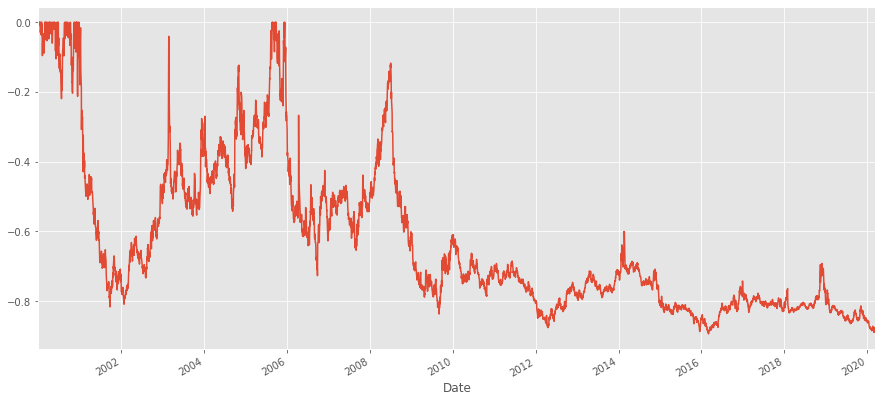

In [0]:
#perf = df.loc['2017-01-01':,['Last']].calc_stats()
perf = df['Last'].calc_stats()
print('\n')

perf.display()
print('\n')

print('\033[4mMonthly returns\033[0m')
print(perf.display_monthly_returns())
print('\n')

ffn.to_drawdown_series(df['Last']).plot(figsize=(15,7),grid=True)
print('\n')

print('\033[4mStatistics\033[0m')
print(perf.stats)
print('\n')


### ***Statistics 2***

Average daily return: 0.0005782341566881827
Average Std deviation (Volatility): 0.035266933630251615
Annualized average return of Natural Gas (Contract#1): 0.15


<IPython.core.display.Javascript object>

Annualized volatility of Natural Gas (Contract#1): 0.56




<IPython.core.display.Javascript object>

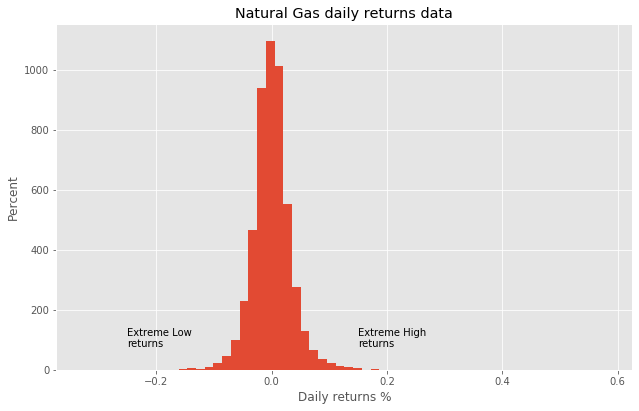



Maximum Drawdown
Maximum Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06    0.000000
2000-01-07   -0.010474
2000-01-10    0.000000
                ...   
2020-03-09   -0.365539
2020-03-10   -0.328915
2020-03-11   -0.343565
2020-03-12   -0.365539
2020-03-13   -0.343216
Name: Last, Length: 5063, dtype: float64


Min Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06   -0.003676
2000-01-07   -0.010474
2000-01-10   -0.010474
                ...   
2020-03-09   -0.559705
2020-03-10   -0.559705
2020-03-11   -0.559705
2020-03-12   -0.559705
2020-03-13   -0.559705
Name: Last, Length: 5063, dtype: float64




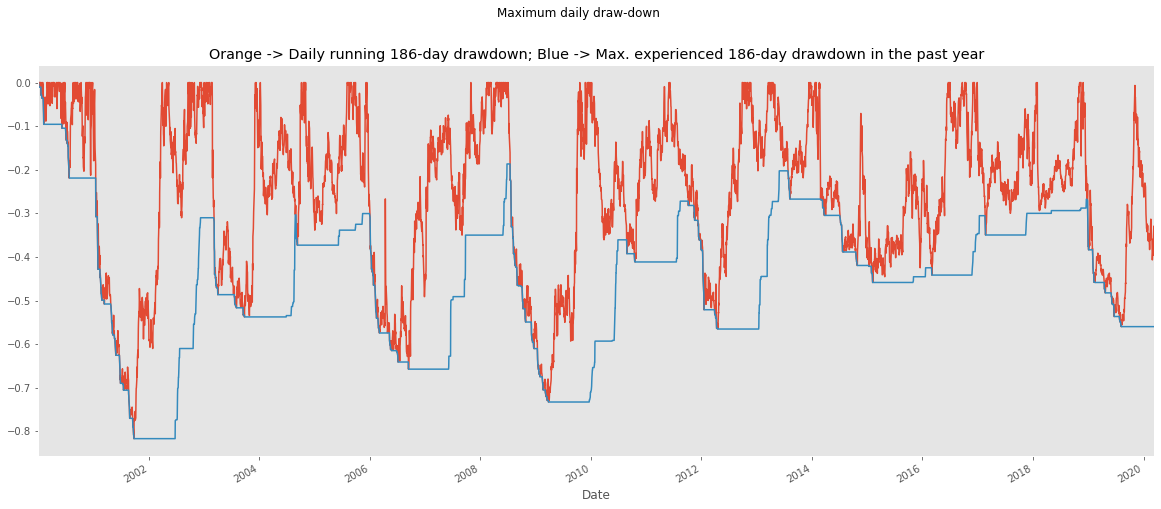

In [0]:
# Calculate the daily percentage change which is daily return
#print('\033[1m' + 'daily percentage change' + '\033[1m')
daily_ret = merge13['Last'].pct_change().fillna(0)
mean_return = daily_ret.mean()
return_stdev = daily_ret.std()
print('Average daily return:',   mean_return )
print('Average Std deviation (Volatility):',  return_stdev)

print ('Annualized average return of Natural Gas (Contract#1):', round(mean_return * 252,2))
print('Annualized volatility of Natural Gas (Contract#1):', round(return_stdev * np.sqrt(252), 2))
print('\n')

#print('\033[4mStatistics summary\033[0m')
#print(merge12.daily_ret.describe())
#print('\n')

#print('\033[4mCritical Values\033[0m')
n = len(daily_ret)
test_statistic = ((daily_ret.mean() - 0) / (daily_ret.std()/np.sqrt(n)))
#print ('t test statistic: ', test_statistic)
#print('\n')

from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, n - 1))
#print ('P-value is: ', p_val)
#print('\n')

from scipy.stats import chi2
# Here we calculate the critical value directly because our df is too high for most chisquare tables
crit_value = chi2.ppf(0.99, (n - 1))
#print ('Critical value at α = 0.01 with 251 df: ', crit_value)
#print('\n')

# +/- %5 daily change distribution in Henry Hub gas prices
#daily_ret.hist(bins=100, range = (-0.05, 0.05), figsize = (15,8))
#plt.title('+/- 5% daily change distribution in Henry Hub gas prices')
#plt.show()
#print('\n')

# Plot the distributions
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_ret.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Natural Gas daily returns data")
ax1.text(-0.25,75,"Extreme Low\nreturns")
ax1.text(0.15,75,"Extreme High\nreturns")
plt.show()
print('\n')
#print ('\033[1m' + 'Shapiro test: W-test, and P-value' + '\033[1m')
#print(stats.shapiro(daily_ret))
#print('\n')
#print("Skewness, Kurtosis : ", daily_ret.skew(), daily_ret.kurtosis())
#print('\n')
#print("T-value P-value (two-tail)")
#print(stats.ttest_1samp(daily_ret, 0.5))
#print(stats.ttest_1samp(daily_ret, 0))
#print('\n')

print('\033[4mMaximum Drawdown\033[0m')
# Using a trailing 186 trading day window
window = 186
# Calculate the max drawdown in the past window days for each day in the series.
# Using min_periods=1, we want to let the first 186 days data have an expanding window
roll_max = df['Last'].rolling(min_periods=1, window=window).max()
# Calculate daily draw-down from rolling max
daily_drawdown = df['Last']/roll_max - 1.0
print('\033[4mMaximum Daily Drawdown\033[0m')
print(daily_drawdown)
print('\n')

# Next we calculate the minimum (negative) daily drawdown in that window.
# using min_periods=1 to allow the expanding window
print('\033[4mMin Daily Drawdown\033[0m')
min_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=window).min()
print(min_daily_drawdown)
print('\n')

# Plot the results
daily_drawdown.plot(figsize=(20,8))
min_daily_drawdown.plot()
plt.title('Orange -> Daily running 186-day drawdown; Blue -> Max. experienced 186-day drawdown in the past year')
plt.suptitle('Maximum daily draw-down')
plt.grid()
plt.show()
print('\n')

In [0]:
#print('\033[4mAverage Sharpe Ratio (risk-adjusted return):: Daily\033[0m')
#sharpe_ratio = daily_ret.mean() / daily_ret.std()
#print('Sharpe Ratio:', sharpe_ratio)
#print('\033[4mSharpe Ratio:: Annual\033[0m')
#an_sharpe_ratio = (252**0.5) * sharpe_ratio # annualised sharpe ratio
#print('Annualized Sharpe Ratio (risk-adjusted return):', an_sharpe_ratio)
#print('\n')

### ***Statistics 3***

In [0]:
print('\033[4mProbability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2000- till date)\033[0m')

print ("The probability of price changes between 1%% and -1%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.01) & (daily_ret < 0.01)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 3%% and -3%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.03) & (daily_ret < 0.03)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 5%% and -5%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.05) & (daily_ret < 0.05)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes more than 5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret > 0.05].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes less than -5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret < -0.05].shape[0] / daily_ret.shape[0]))
print('\n')

print('\033[4mMinimum price [2000- till date]\033[0m')
print(df['Last'].min(), df['Last'].idxmin());
print('\033[4mMaximum price [2000- till date]\033[0m')
print(df['Last'].max(), df['Last'].idxmax());
print('\n')

print('\033[4mMinimum daily % return [2000- till date]\033[0m')
print(daily_ret.min(), daily_ret.idxmin()); 
print('\033[4mMaximum daily % return [2000- till date]\033[0m')
print(daily_ret.max(), daily_ret.idxmax());
print('\n')

Probability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2000- till date)
The probability of price changes between 1% and -1% is 28.48% 
The probability of price changes between 3% and -3% is 72.17% 
The probability of price changes between 5% and -5% is 89.29% 
The probability of price changes more than 5% is 5.91%
The probability of price changes less than -5% is 4.80%


Minimum price [2000- till date]
1.632 2016-03-03 00:00:00
Maximum price [2000- till date]
15.378 2005-12-13 00:00:00


Minimum daily % return [2000- till date]
-0.32798226164079824 2006-04-17 00:00:00
Maximum daily % return [2000- till date]
0.5802382620882973 2006-04-14 00:00:00




# **Supervised Machine Learning**

## **Buy & Sell signals**

This is a classification variable, average price will go either up or down the next day.
The target variables transformed for binary classification. A positive change in the value of prices classified as 1 and a non-positive change as 0.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0]	validation_0-auc:0.94491	validation_1-auc:0.923657
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[10]	validation_0-auc:0.957899	validation_1-auc:0.941319
[20]	validation_0-auc:0.958357	validation_1-auc:0.942003
Stopping. Best iteration:
[17]	validation_0-auc:0.95877	validation_1-auc:0.944036

Model performance :: Quality of Classifier


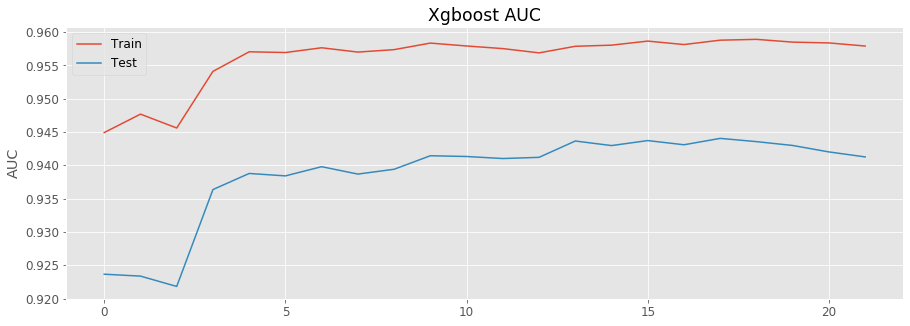

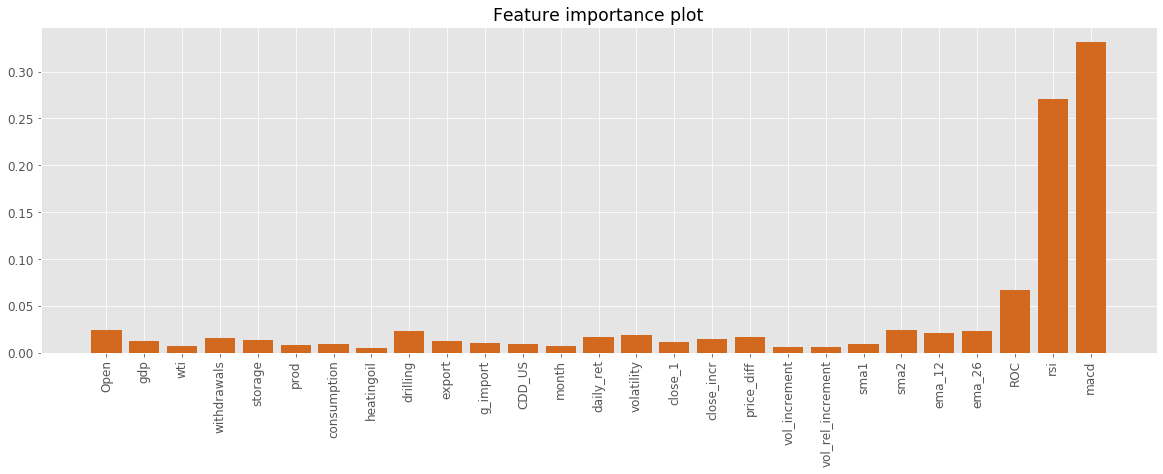



Next day Open price direction


<IPython.core.display.Javascript object>

     0
838  0
839  0
840  0
841  0
842  1


Area under ROC curve: 94.40355518055254


For each day where open price = 0 = red arrow head  and 1 = green arrow head 


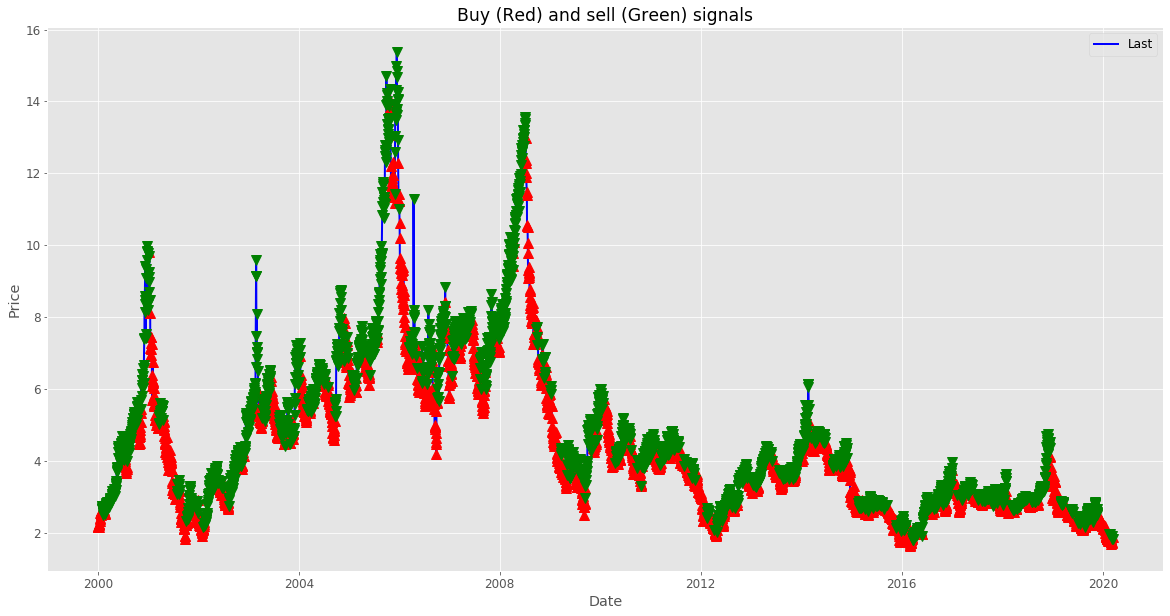

In [0]:
# Target Variable
print('\033[4mThis is a classification variable, average price will go either up or down the next day.\033[0m')
#This will be a classification variable, if the average price will go either up or down the next day.  
#The target will be forecasting the difference between today’s price and tomorrow’s price (which is unkonwn).
df['target'] = (df['sma1'].shift(-1) - df['sma1'])
df = df.fillna(0)
df['target'].tail()
#print('\n')

def getBinary(val):
    if val > 0:
      return 1
    else:
      return 0
df['next_day_direction'] = df["target"].apply(getBinary)
print('\033[4mThe target variables transformed for binary classification. A positive change in the value of prices classified as 1 and a non-positive change as 0.\033[0m')

#The target variables will be transformed for binary classification. 
#A positive change in the value of prices will be classified as 1 and a non-positive change as 0.
#print(df.tail())
#print('\n')

y = df['next_day_direction']
x = df.drop(columns = ['next_day_direction', 'target', 'Last', 'High', 
                       'Low', 'Volume', 'Settle', 'Change', 'Previous Day Open Interest',
                       'day_of_week', 'day_of_month', 'HDD_US', 'quarter', 'year'])

X = np.array(x)
y = np.array(y)
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

eval_set = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]
xgb_clf1 = XGBClassifier(learning_rate= 0.01,
                         max_depth= 5,
                         min_child_weight= 3,
                         n_estimators= 700,
                         subsample =1,
                         colsample_bytree = 0.5,
                         gamma = 1)
xgb_clf1.fit(X_train, y_train, 
             eval_metric = 'auc', eval_set = eval_set,
             early_stopping_rounds = 5, verbose = 10)

print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf1.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

# we can then access the best number of tree and use it later for prediction
#print('best iteration', xgb_clf1.best_ntree_limit)
#print('\n')

# Feature importance
fig = plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_clf1.feature_importances_))], xgb_clf1.feature_importances_.tolist(), 
        tick_label=x.columns, color="chocolate")
plt.title('Feature importance plot')
plt.show()
print('\n')

# print the model's performance
ntree_limit = xgb_clf1.best_ntree_limit
print('\033[4mNext day Open price direction\033[0m')
pred = xgb_clf1.predict(X_test, ntree_limit = ntree_limit)
pred = pd.DataFrame(pred)
print(pred.tail())
print('\n')

pred_prob = xgb_clf1.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('Area under ROC curve:', roc_auc_score(y_test, pred_prob)*100)
print('\n')

#print('\033[4mProbability of prediction results\033[0m')
#pred_prob = pd.DataFrame(pred_prob)
#print(pred_prob.tail())
#print('\n')


# For each day where open price > 0, we set the signal 1 means sell  and < 0, we set signal 0, to buy 
print('\033[4mFor each day where open price = 0 = red arrow head  and 1 = green arrow head \033[0m')
buys = df.loc[df['next_day_direction'] == 0]
sells = df.loc[df['next_day_direction'] == 1]

# Plot 
fig = plt.figure(figsize=(20,10))
plt.plot(df.index, df['Last'], color = 'b', lw=2., label='Last')

# Plot the buy and sell signals on the same plot
plt.plot(buys.index, df.loc[buys.index]['Last'], '^', markersize=10, color='r')
plt.plot(sells.index, df.loc[sells.index]['Last'], 'v', markersize=10, color='g')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Buy (Red) and sell (Green) signals')
plt.legend(loc=0)

# Display everything
plt.show()
print('\n')


### **Hyperparameter tunning**

In [0]:
# Hyperparameter optimization
#xgb = xgb_clf1.fit(X_train, y_train, early_stopping_rounds=50,  eval_metric="logloss", eval_set=[(X_test, y_test)])

# scores
#from  sklearn.metrics import log_loss
#log_train = log_loss(y_train, xgb.predict_proba(X_train)[:,1])
#log_valid = log_loss(y_test, xgb.predict_proba(X_test)[:,1])


#print('\n-----------------------')
#print('  logloss train: %.5f'%log_train)
#print('  logloss valid: %.5f'%log_valid)
#print('-----------------------')

#print('\nModel parameters...')
#print(xgb.get_params())

### ***Last 5 Buy/Sell Signals price***

In [0]:
print('\033[4mLast 5 Buy signal \033[0m')
print(df.loc[buys.index]['Last'].tail())
print('\n')
print('\033[4mLast 5 Sell signal \033[0m')
print(df.loc[sells.index]['Last'].tail())

Last 5 Buy signal 
Date
2020-03-04    1.835
2020-03-05    1.757
2020-03-06    1.731
2020-03-11    1.882
2020-03-13    1.883
Name: Last, dtype: float64


Last 5 Sell signal 
Date
2020-02-18    1.969
2020-02-19    1.967
2020-03-09    1.819
2020-03-10    1.924
2020-03-12    1.819
Name: Last, dtype: float64


## **Moving averages crossover**

<IPython.core.display.Javascript object>

Sell-> Shorter MA crosses above the longer-term MA (Golden cross)
Buy-> Shorter MA crosses below the longer-term MA(Dead cross)


Buys data to checking
Date
2020-03-09    1.819
2020-03-10    1.924
2020-03-11    1.882
2020-03-12    1.819
2020-03-13    1.883
Name: Last, dtype: float64


Sells data to checking
Date
2019-02-12    2.667
2019-02-13    2.588
2019-02-14    2.567
2019-02-15    2.632
2019-02-19    2.659
Name: Last, dtype: float64


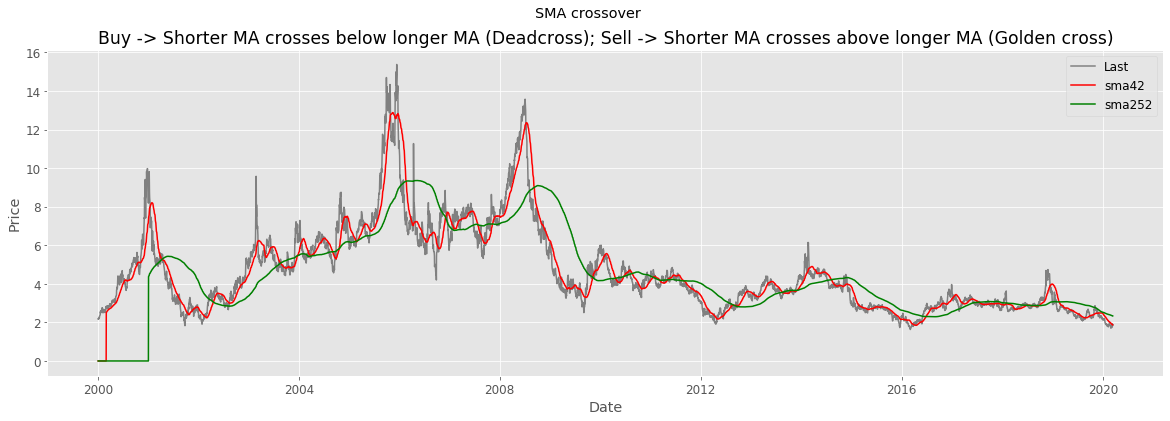

In [0]:
## Moving averages crossover [2 months and 1 year look back]
merge14 = merge12.apply(copy.deepcopy)

# feature engineering
merge14['day_of_week'] = merge14.index.dayofweek
merge14['day_of_month'] = merge14.index.day
merge14['quarter'] = merge14.index.quarter
merge14['month'] = merge14.index.month
merge14['year'] = merge14.index.year

# Technical indicators
merge14['daily_ret'] = merge14['Last'].pct_change()
#merge14['volatility'] = merge14['daily_ret'].rolling(252).std()*(252**0.5)
merge14["Last_1"] = merge14['Last'].shift(1)
merge14["Last_incr"] = merge14['Last'] - merge14['Last'].shift(1)
merge14['price_diff'] = merge14['Last'] - merge14['Open']
merge14["vol_increment"] = merge14['Volume'].diff()
merge14["vol_rel_increment"] = merge14['Volume'].diff() / merge14['Volume']

sma1 = 42
sma2 = 252
merge14["sma1"] = merge14['Last'].rolling(sma1).mean().fillna(0)
merge14["sma2"] = merge14['Last'].rolling(sma2).mean().fillna(0)
merge14['ema42'] = merge14['Last'].ewm(span=42).mean().fillna(0)
merge14['ema252'] = merge14['Last'].ewm(span=252).mean().fillna(0)

merge14['ema_12'] = merge14['Last'].ewm(span=10).mean().fillna(0)
merge14['ema_26'] = merge14['Last'].ewm(span=26).mean().fillna(0)
merge14['ROC'] = ((merge14['Last'] - merge14['Last'].shift(5)) / (merge14['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge14['rsi'] = 100-100/(1+RS_up/RS_down)
merge14['macd'] = merge14['ema_12'] - merge14['ema_26']


df1 = merge14.apply(copy.deepcopy)
df1.fillna(-99999, inplace=True)

# moving average crossover :: sma 252 is > sma 42
df1['target'] = np.where(df1['sma1'] > df1['sma2'], 1,0)
df1 = df1.fillna(0)
df1['target'].tail()
#print('\n')

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
df1['next_day_direction'] = df1["target"].apply(getBinary)


print('\033[4mSell-> Shorter MA crosses above the longer-term MA (Golden cross)\033[0m')
print('\033[4mBuy-> Shorter MA crosses below the longer-term MA(Dead cross)\033[0m')
buys = df1.loc[df1['next_day_direction'] == 0]
sells = df1.loc[df1['next_day_direction'] == 1]
print('\n')

print("\033[4mBuys data to checking\033[0m")
print(df1.loc[buys.index]['Last'].tail())
print('\n')
print("\033[4mSells data to checking\033[0m")
print(df1.loc[sells.index]['Last'].tail())

# Plot 
fig = plt.figure(figsize=(20,6))
plt.plot(merge14['Last'], color='gray', label='Last')
# Plot the buy and sell signals on the same plot
#  When the shorter-term MA crosses above the longer-term MA (Golden cross), it's a buy signal, it indicates that the trend is shifting up. 
#  When the shorter-term MA crosses below the longer-term MA, it's a sell signal (dead/death cross), it indicates that the trend is shifting down. 
plt.plot(merge14['sma1'].dropna(), color='r', label = 'sma42')
plt.plot(merge14['sma2'].dropna(), color='g', label = 'sma252')
plt.ylabel('Price')
plt.xlabel('Date')
plt.suptitle('SMA crossover')
plt.title('Buy -> Shorter MA crosses below longer MA (Deadcross); Sell -> Shorter MA crosses above longer MA (Golden cross)')
plt.legend(loc=0)

# Display everything
plt.show()
print('\n')


## **5 days look-ahead Open price**


In [0]:
## 5 days look-ahead Open price

# Technical indicators
merge16 = merge12.apply(copy.deepcopy)

merge16['pct_change'] = merge16['Open'].pct_change()
merge16["vol_rel_increment"] = merge16['Volume'].diff() / merge16['Volume']
merge16['std_5'] = merge16['pct_change'].rolling(5).std()
merge16['ret_5'] = merge16['pct_change'].rolling(5).mean()
merge16['sma42'] = merge16['Open'].rolling(42).mean()
merge16['sma252'] = merge16['Open'].rolling(252).mean()
merge16['ema_12'] = merge16['Open'].ewm(span=10).mean()
merge16['ema_26'] = merge16['Open'].ewm(span=26).mean()
merge16['ROC'] = ((merge16['Open'] - merge16['Open'].shift(5)) / (merge16['Open'].shift(5)))*100

delta = merge16['Open'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge16['rsi'] = 100-100/(1+RS_up/RS_down)
merge16['macd'] = merge16['ema_12'] - merge16['ema_26']

df4 = merge16.apply(copy.deepcopy)
df4.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df4['Prediction'] = df4[['Open']].shift(-forecast_out) #  label column with data shifted 5 units up
df4.dropna(inplace=True)
#print(df4.tail(3))

X3 = df4.drop(columns = ['Prediction', 'Last', 'High', 'Low', 'Volume', "Settle"])
X3 = np.array (df4.drop(['Prediction'],1))
X3_forecast = X3[-forecast_out:] # set X_forecast equal to last 5, we do not have y values for X_forecast
X3 = X3[:-forecast_out] # remove last 5 from X
y3 = np.array(df4['Prediction'])
y3 = y3[:-forecast_out]
#print(len(X3), len(y3))

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.33, random_state=42)

reg2 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg2.fit(X3_train, y3_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg2, X3_train, y3_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg2.score(X3_test, y3_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_2 = reg2.predict(X3_forecast)
#print('\033[4mExpected Open price for next 5 days\033[0m')
#print(forecast_pred_2)
#print('\n')

# assiging date to the predicted values
merge16['Forecast'] = np.nan
last_date = merge16.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in forecast_pred_2:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  merge16.loc[next_date] = [np.nan for _ in range(len(merge16.columns)-1)] + [i]

#create an index of just the date portion of your index (this is the slow step)
ts_days = pd.to_datetime(merge16['Forecast'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=merge16['Forecast'].index[0].date(), end=merge16['Forecast'].index[-1].date())

#Filter the series to just those days contained in the business day range.
merge16['Forecast'] = merge16.Forecast[ts_days.isin(bdays)]
print('\033[4mExpected Open price for next 5 days\033[0m')
merge16['Forecast'].tail()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtesting
K-fold CV average score: 0.98


confidence:  0.9805413086141532




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Expected Open price for next 5 days


Date
2020-03-14         NaN
2020-03-15         NaN
2020-03-16    1.940229
2020-03-17    1.940229
2020-03-18    1.958419
Name: Forecast, dtype: float64

## **5 days look-ahead Close price**

In [0]:
# Technical indicators
merge15 = merge12.apply(copy.deepcopy)

merge15['pct_change'] = merge15['Last'].pct_change()
merge15['std_5'] = merge15['pct_change'].rolling(5).std()
merge15['ret_5'] = merge15['pct_change'].rolling(5).mean()
merge15['HL_pct'] = merge15['High'] - merge15['Low'] / merge15['Low']
merge15['price_diff'] = merge15['Last'] - merge15['Open']
merge15["vol_rel_increment"] = merge15['Volume'].diff() / merge15['Volume']
merge15['sma42'] = merge15['Last'].rolling(42).mean()
merge15['ema_12'] = merge15['Last'].ewm(span=10).mean()
merge15['ema_26'] = merge15['Last'].ewm(span=26).mean()
merge15['ROC'] = ((merge15['Last'] - merge15['Last'].shift(5)) / (merge15['Last'].shift(5)))*100

delta = merge15['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge15['rsi'] = 100-100/(1+RS_up/RS_down)
merge15['macd'] = merge15['ema_12'] - merge15['ema_26']

df3 = merge15.apply(copy.deepcopy)
df3.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df3['Prediction'] = df3[['Last']].shift(-forecast_out) #  label column with data shifted 21 units up

X2 = df3.drop(columns = ['Prediction', 'Open', 'High', 'Low', 'Volume', "Settle"])
X2 = np.array(X2)
X2_forecast = X2[-forecast_out:] # set X1_forecast equal to last 5, we do not have y values for X_forecast
X2 = X2[:-forecast_out] # remove last 5 from X1
y2 = np.array(df3['Prediction'])
y2 = y2[:-forecast_out]
df3.dropna(inplace=True)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.33, random_state=42)

reg1 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg1.fit(X2_train, y2_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg1, X2_train, y2_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg1.score(X2_test, y2_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_1 = reg1.predict(X2_forecast)
#print('\033[4mExpected Close price for next 5 days\033[0m')
#print(forecast_pred_1)
#print('\n')

# assiging date to the predicted values
merge15['Forecast'] = np.nan
last_date = merge15.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in forecast_pred_1:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  merge15.loc[next_date] = [np.nan for _ in range(len(merge15.columns)-1)] + [i]

#create an index of just the date portion of your index (this is the slow step)
ts_days = pd.to_datetime(merge15['Forecast'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=merge15['Forecast'].index[0].date(), end=merge15['Forecast'].index[-1].date())

#Filter the series to just those days contained in the business day range.
merge15['Forecast'] = merge15.Forecast[ts_days.isin(bdays)]
print('\033[4mExpected Close price for next 5 days\033[0m')
merge15['Forecast'].tail()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtesting
K-fold CV average score: 0.97


confidence:  0.9777837541629504




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Expected Close price for next 5 days


Date
2020-03-14         NaN
2020-03-15         NaN
2020-03-16    1.974760
2020-03-17    1.972231
2020-03-18    1.971213
Name: Forecast, dtype: float64

#**Week, month, year historical analysis**

Natural Gas continuous contract 1
Print 1st & last 5 rows
           Date   Open   High    Low   Last    Volume
0    2000-01-04  2.180  2.200  2.130  2.176   30152.0
1    2000-01-05  2.180  2.200  2.125  2.168   27946.0
2    2000-01-06  2.175  2.220  2.165  2.196   29071.0
3    2000-01-07  2.210  2.230  2.155  2.173   28455.0
4    2000-01-10  2.180  2.255  2.165  2.216   28916.0
...         ...    ...    ...    ...    ...       ...
5058 2020-03-09  1.678  1.830  1.610  1.819  289959.0
5059 2020-03-10  1.835  1.955  1.794  1.924  345971.0
5060 2020-03-11  1.938  1.998  1.860  1.882  316875.0
5061 2020-03-12  1.883  1.883  1.750  1.819  275312.0
5062 2020-03-13  1.810  1.951  1.795  1.883  213924.0

[5063 rows x 6 columns]


Feature engineering- Adding Weeks, Months and Year Columns
Print last 5 rows
           Date   Open   High    Low   Last    Volume  week_no  month_no  year  DayofWeek
5058 2020-03-09  1.678  1.830  1.610  1.819  289959.0       11         3  2020          0
5059 2020-

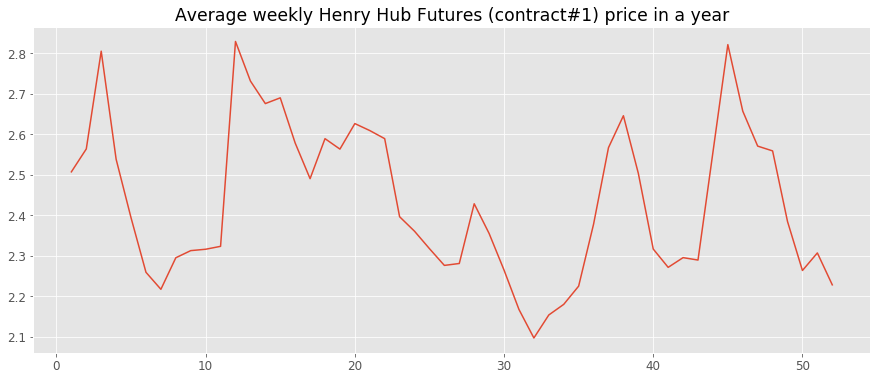

The plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.


Average Weekly Gas Prices Pivot Table
Print last 5 rows


<IPython.core.display.Javascript object>

year      2000      2001    2002      2003     2004      2005     2006    2007     2008    2009     2010     2011     2012     2013    2014  \
week_no                                                                                                                                       
49       8.180  2.565000  4.2700  5.645000  7.59600  13.95560  7.76600  7.2260  6.37920  4.7386  4.45860  3.47740  3.60820  3.99500  3.8648   
50       8.354  2.734000  4.6290  6.727000  6.86280  14.59220  7.49000  7.1688  5.64600  4.9750  4.27840  3.21000  3.42040  4.27460  3.6822   
51       9.430  2.736000  5.2220  6.875000  7.15640  13.79240  6.90400  7.1066  5.63940  5.4750  4.12125  3.13420  3.36640  4.31380  3.7298   
52       9.455  2.813333  5.0725  6.233333  6.95125  11.36125  6.06125  7.0635  5.53925  5.7625  4.21020  3.09175  3.38875  4.45775  3.1895   
53         NaN       NaN     NaN       NaN  6.36375       NaN      NaN     NaN      NaN  5.8215      NaN      NaN      NaN      NaN     NaN   

<IPython.core.display.Javascript object>

year          2000      2001      2002      2003      2004       2005      2006      2007       2008      2009      2010      2011      2012  \
month_no                                                                                                                                       
1         2.385263  7.895714  2.215476  5.373810  6.367368   6.178650  9.225500  6.704045   7.976762  5.124400  5.612944  4.495150  2.727900   
2         2.599750  5.705789  2.256842  6.525000  5.353947   6.194895  7.675263  7.589750   8.598250  4.385944  5.266722  4.061947  2.527800   
3         2.818913  5.228409  2.969750  5.849762  5.526478   6.993909  6.969304  7.206955   9.644842  4.032455  4.342348  4.050591  2.315952   
4         3.025263  5.206000  3.424091  5.337381  5.769286   7.198810  7.472700  7.628350  10.248318  3.585905  4.092429  4.267737  2.064571   
5         3.560909  4.252955  3.564091  5.865000  6.370950   6.496667  6.402500  7.802783  11.384600  3.922600  4.141450  4.340619  2.49

In [0]:
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint 1st & last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG)
print('\n')

# feature engineering
#Adding Weeks, Months and Year Columns
print('\033[4mFeature engineering- Adding Weeks, Months and Year Columns\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG['week_no'] = NG['Date'].dt.week
NG['month_no'] = NG['Date'].dt.month
NG['year'] = NG['Date'].dt.year
NG['DayofWeek'] = NG['Date'].dt.dayofweek
print(NG.tail())
print('\n')

fig = plt.figure(figsize=(15,6))
plt.plot(NG[NG.year >= 2019].groupby('week_no')['Open'].mean().head(52))
plt.title('Average weekly Henry Hub Futures (contract#1) price in a year')
plt.show()
print ('\033[4mThe plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.\033[0m')
print('\n')

# Average Weekly Gas Prices Pivot Table
print('\033[4mAverage Weekly Gas Prices Pivot Table\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
pivot_ng = NG.pivot_table(values = 'Open', columns = ['year'], aggfunc= np.mean,index = ['week_no'])
print(pivot_ng.tail()) # last 5 rows
print('\n')

# Average Monthly Gas Prices & Percent Changes
print('\033[4mAverage Monthly Gas Prices\033[0m')
monthly = NG.pivot_table(values= 'Open', columns = ['year'],aggfunc = np.mean, index = ['month_no'])
print(monthly) 
print('\n')

monthly.loc[0] = monthly.loc[12,:].shift(1)
monthly.fillna(method='ffill', inplace=True) # filling nan values with previous data
monthly = monthly.sort_index()
print(monthly)
print('\n')

print('\033[4mAverage monthly gas prices % change\033[0m')
monthly_change = monthly.pct_change()
# dropping the 1st row
monthly_change = monthly_change.drop(monthly_change.index[0])
print(monthly_change)
print('\n')

print('\033[4mProbabilities of Monthly Gas Price Decline vs Raise\033[0m')
print('\033[4mProbability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.\033[0m')
monthly_change['raise'] = monthly_change[(monthly_change.iloc
                                                              [:,:]>0)].count(axis=1)/(2020-2000)
monthly_change['decline'] = monthly_change[(monthly_change.iloc
                                                              [:,:]<0)].count(axis=1)/(2020-2000)   
print(monthly_change[['raise', 'decline']])  